<a href="https://colab.research.google.com/github/Camicb/practice/blob/main/Travel_Insurance_Claim_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Travel Insurance Claim Prediction**

#1. Introduction

Many companies selling tickets or travel packages, give consumers the option to purchase travel insurance, also known as travelers insurance. Travel insurance is a type of insurance that covers the costs and losses associated with traveling. It is useful protection for those traveling domestically or abroad.
Some travel policies cover damage to personal property, rented equipment, such as rental cars, or even the cost of paying a ransom. 

The objective of this project is to create a machine learning model for a insurance company to predict if the insurance buyer will claim their travel insurance or not.

#2. Import Required Libraries

In [1]:
#!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip 
#!pip install pycaret

In [2]:
#Importing libraries
import pandas as pd
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno 
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from sklearn import set_config
from pycaret.utils import enable_colab
enable_colab()

Colab mode enabled.


#3. Exploratory Data Analysis
##3.1 About the data
There are 11 columns in the dataset:
*   **Duration:** Travel duration
*   **Destination:** Travel destination (country)
*   **Agency:** Agency Name
*   **Agency Type:** Travel Agency or Airlines 
*   **Commission (in value):** Commission on the insurance
*   **Age:** Age of the insurance buyer
*   **Gender:** Gender of the insurance buyer
*   **Distribution Channel:** offline/online
*   **Product Name:** Name of the insurance plan
*   **Net Sales:** Net sales
*   **Claim:** If the insurance is claimed or not (the target variable), 0 = not claimed, 1 = claimed


In [3]:
# Load the provided data into a pandas data frame 
ins = pd.read_csv("https://raw.githubusercontent.com/dphi-official/Datasets/master/travel_insurance/Training_set_label.csv" ) # training data
test_ins = pd.read_csv('https://raw.githubusercontent.com/dphi-official/Datasets/master/travel_insurance/Testing_set_label.csv') # testing data

## 3.2 Exploratory data analysis

In [4]:
ins.head()
ins.info()

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Gender,Age,Claim
0,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,61,UNITED KINGDOM,19.8,11.88,NaN,29,0
1,EPX,Travel Agency,Online,Cancellation Plan,93,NEW ZEALAND,63.0,0.00,NaN,36,0
2,EPX,Travel Agency,Online,2 way Comprehensive Plan,22,UNITED STATES,22.0,0.00,NaN,25,0
3,C2B,Airlines,Online,Silver Plan,14,SINGAPORE,54.5,13.63,M,24,0
4,EPX,Travel Agency,Online,Cancellation Plan,90,VIET NAM,10.0,0.00,NaN,23,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48260 entries, 0 to 48259
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                48260 non-null  object 
 1   Agency Type           48260 non-null  object 
 2   Distribution Channel  48260 non-null  object 
 3   Product Name          48260 non-null  object 
 4   Duration              48260 non-null  int64  
 5   Destination           48260 non-null  object 
 6   Net Sales             48260 non-null  float64
 7   Commision (in value)  48260 non-null  float64
 8   Gender                13899 non-null  object 
 9   Age                   48260 non-null  int64  
 10  Claim                 48260 non-null  int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 4.1+ MB


In [5]:
test_ins.head()
test_ins.info()

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Gender,Age
0,EPX,Travel Agency,Online,Cancellation Plan,24,HONG KONG,27.0,0.0,NaN,36
1,EPX,Travel Agency,Online,Cancellation Plan,51,JAPAN,45.0,0.0,NaN,36
2,EPX,Travel Agency,Online,Cancellation Plan,52,JAPAN,21.0,0.0,NaN,21
3,EPX,Travel Agency,Online,Cancellation Plan,89,SINGAPORE,11.0,0.0,NaN,30
4,EPX,Travel Agency,Online,Cancellation Plan,5,MALAYSIA,10.0,0.0,NaN,33


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15832 entries, 0 to 15831
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                15832 non-null  object 
 1   Agency Type           15832 non-null  object 
 2   Distribution Channel  15832 non-null  object 
 3   Product Name          15832 non-null  object 
 4   Duration              15832 non-null  int64  
 5   Destination           15832 non-null  object 
 6   Net Sales             15832 non-null  float64
 7   Commision (in value)  15832 non-null  float64
 8   Gender                4546 non-null   object 
 9   Age                   15832 non-null  int64  
dtypes: float64(2), int64(2), object(6)
memory usage: 1.2+ MB


In [6]:
# Statistic report
profile = ProfileReport(ins, html={'style': {'full_width': True, 'primary_color': '#30b6c2'}},  samples=None, missing_diagrams=None, interactions=None)
profile.to_file("report.html")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/24 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

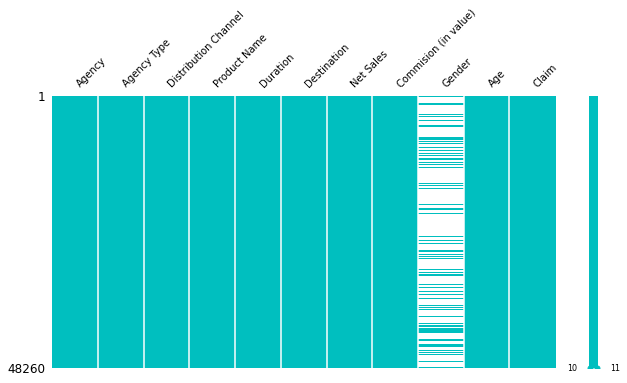

In [7]:
# Visualization of missing values 
msno.matrix(ins, figsize=(10,5), fontsize=10, color=(0.0, 0.75, 0.75)) 

# 4. Preprocessing

Changes in the testing data are executed in order to maintain a consistent shape with the training data. Since 'Gender' has too many missing values and the 'Distribution Channel' is highly correlated to others variables and presents imbalanced classes, the entire columns will be removed. A new class, 'Other', will be created for elements with small frequencies along the variables. Outliers will be transformed into NaN values for posterior imputation.

## 4.1 Agency 


([0, 1, 2, 3, 4, 5, 6, 7, 8], <a list of 9 Text major ticklabel objects>)

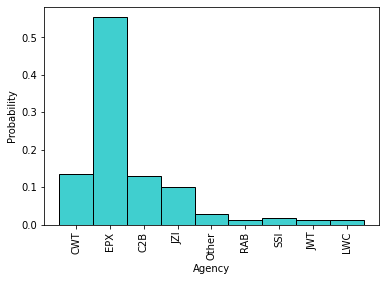

In [8]:
# Replacing the agencies with a frequency smaller than 1% to 'Other' 
Agencies=ins.loc[:,'Agency'].value_counts(normalize=True)*100
Agencies=list(Agencies[Agencies < 1].index)

ins.loc[:,'Agency']=ins.loc[:,'Agency'].apply(lambda i: 'Other' if i in Agencies else i)
test_ins.loc[:,'Agency']=test_ins.loc[:,'Agency'].apply(lambda i: 'Other' if i in Agencies else i)


sns.histplot(data=ins, x='Agency', color='c', stat='probability')
plt.xticks(rotation='vertical')

##4.2 Product Name

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 <a list of 11 Text major ticklabel objects>)

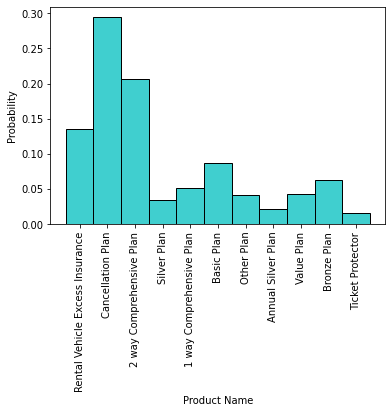

In [9]:
# Replacing the products with a frequency smaller than 1% to 'Other Plan'
Products=ins.loc[:, 'Product Name'].value_counts(normalize=True)*100
Products=list(Products[Products < 1].index)

ins['Product Name']=ins['Product Name'].apply(lambda i: 'Other Plan' if i in Products else i)
test_ins['Product Name']=test_ins['Product Name'].apply(lambda i: 'Other Plan' if i in Products else i)

sns.histplot(data=ins, x='Product Name', color='c', stat='probability')
plt.xticks(rotation='vertical')

##4.3 Duration and Age

In [10]:
# Transforming the values equal or smaller than zero for Duration and equal to 118 for Age for being clearly outliers.
ins['Duration']= ins.loc[:, 'Duration'].apply(lambda i: np.nan if i < 1 else i)
ins['Duration'].isnull().value_counts(normalize=True)*100
print('---')
ins['Age']= ins.loc[:,'Age'].apply(lambda i: np.nan if i == 118 else i)
ins['Age'].isnull().value_counts(normalize=True)*100

False    99.89225
True      0.10775
Name: Duration, dtype: float64

---


False    98.439702
True      1.560298
Name: Age, dtype: float64

##4.4 Destination

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 <a list of 18 Text major ticklabel objects>)

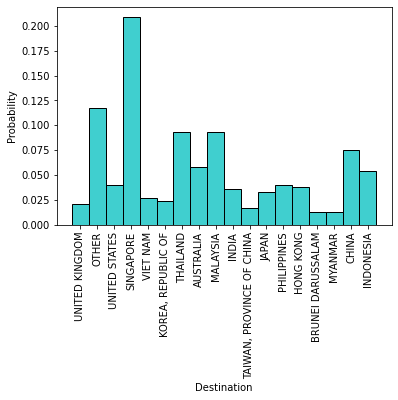

In [11]:
# Replacing the Destinations with a frequency smaller than 1% to 'OTHER'
Destination=ins.loc[:, 'Destination'].value_counts(normalize=True)*100
Destination=list(Destination[Destination > 1].index)

ins['Destination']=ins['Destination'].apply(lambda i: 'OTHER' if i not in Destination else i)
test_ins['Destination']=test_ins['Destination'].apply(lambda i: 'OTHER' if i not in Destination else i)

sns.histplot(data=ins, x='Destination', color='c', stat='probability')
plt.xticks(rotation='vertical')

##4.5 Gender and  Distribution Channel

In [12]:
ins=ins.drop(['Gender', 'Distribution Channel'], axis=1)
test_ins=test_ins.drop(['Gender', 'Distribution Channel'], axis=1)

In [13]:
# Checking the shape of the data for modeling
ins.shape
test_ins.shape

(48260, 9)

(15832, 8)

# 5. Modeling
  
I will use a python library called Pycaret to perform more preprocessing to the data and to compare possible models to adress this problem, and then I will select some of them to work with. 

In [14]:
# Setting up enviroment (more preproccesing)
from pycaret.classification import *

clf=setup(ins, target='Claim',
          train_size=0.85,
          normalize=True,
          normalize_method='minmax',
          feature_selection=True, 
          feature_selection_method='boruta',
          fix_imbalance=True, 
          data_split_stratify=True,
          session_id=123)

,Description,Value
0,session_id,123
1,Target,Claim
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(48260, 9)"
5,Missing Values,True
6,Numeric Features,4
7,Categorical Features,4
8,Ordinal Features,False
9,High Cardinality Features,False


In [15]:
# Comparing classifiers 
compare_models(sort='F1')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
svm,SVM - Linear Kernel,0.8620,0.0000,0.6163,0.0641,0.1160,0.0919,0.1665,0.171
lightgbm,Light Gradient Boosting Machine,0.9172,0.7871,0.3702,0.0686,0.1156,0.0932,0.1315,0.711
ridge,Ridge Classifier,0.8551,0.0000,0.6263,0.0619,0.1127,0.0884,0.1640,0.075
lda,Linear Discriminant Analysis,0.8540,0.8125,0.6263,0.0615,0.1119,0.0876,0.1631,0.151
qda,Quadratic Discriminant Analysis,0.8485,0.8023,0.6412,0.0605,0.1106,0.0860,0.1635,0.092
catboost,CatBoost Classifier,0.9635,0.7527,0.1411,0.0817,0.1032,0.0861,0.0895,30.873
lr,Logistic Regression,0.8315,0.8157,0.6561,0.0557,0.1026,0.0777,0.1559,0.542
nb,Naive Bayes,0.8319,0.7900,0.6511,0.0554,0.1022,0.0772,0.1547,0.075
xgboost,Extreme Gradient Boosting,0.9545,0.7479,0.1743,0.0710,0.1009,0.0817,0.0906,14.588
gbc,Gradient Boosting Classifier,0.8111,0.8050,0.6395,0.0486,0.0904,0.0649,0.1381,7.472


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.001, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
              power_t=0.5, random_state=123, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

I will use the 2 top classifiers to create the models

## 5.1 Support Vector Machine (SVM) - Linear Kernel

In [16]:
# Creating the model 1
svm=create_model('svm', verbose=False)

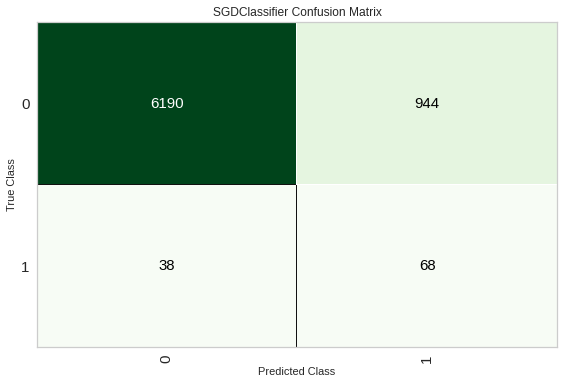

In [17]:
# Analizing the model through plots
plot_model(svm, plot = 'confusion_matrix')


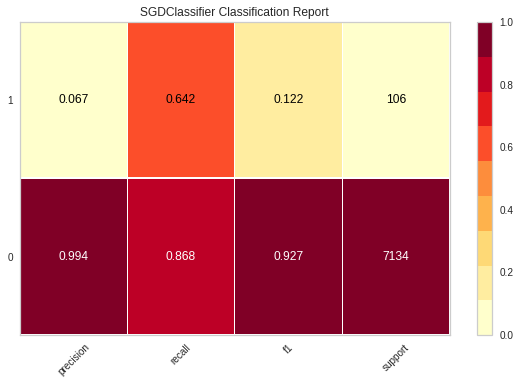

In [18]:
plot_model(svm, plot = 'class_report')

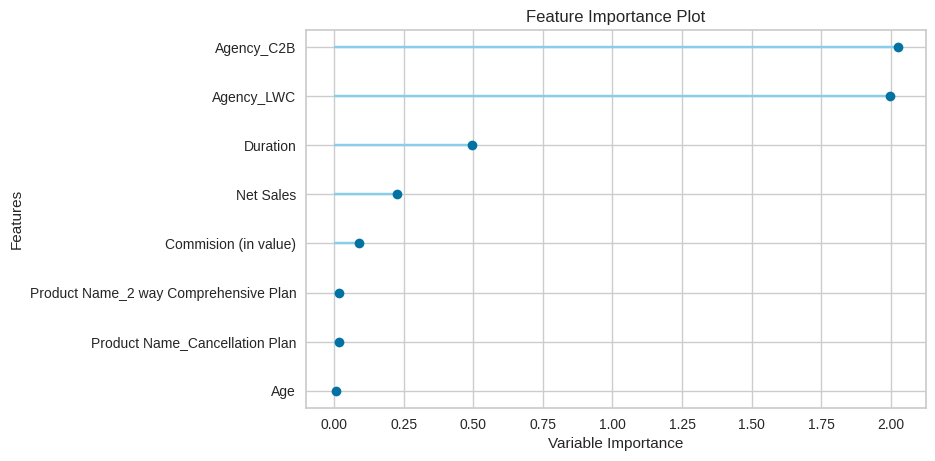

In [19]:
plot_model(svm, plot = 'feature')

## 5.2 LightGBM

In [20]:
# Creating the model 2
lightGBM=create_model('lightgbm', learning_rate=0.15, verbose=False)

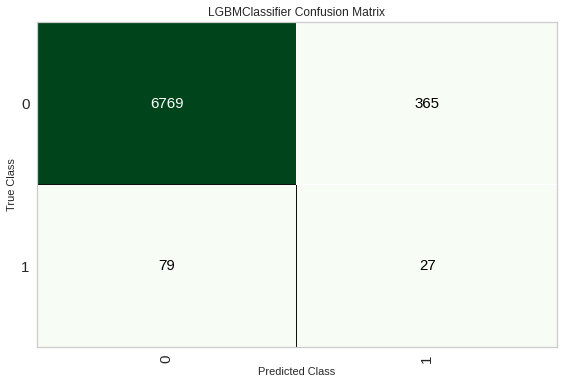

In [21]:
plot_model(lightGBM, plot = 'confusion_matrix')

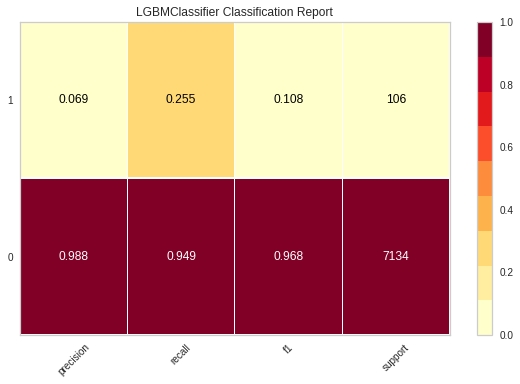

In [22]:
plot_model(lightGBM, plot = 'class_report')

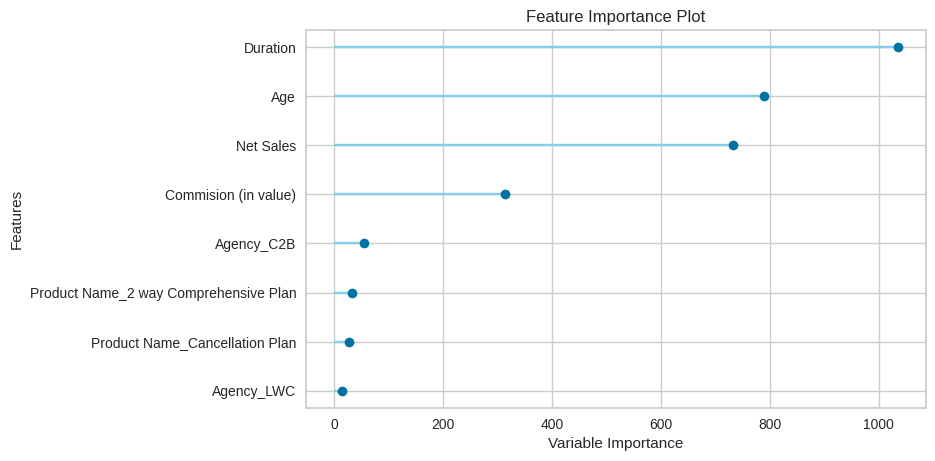

In [23]:
plot_model(lightGBM, plot = 'feature')

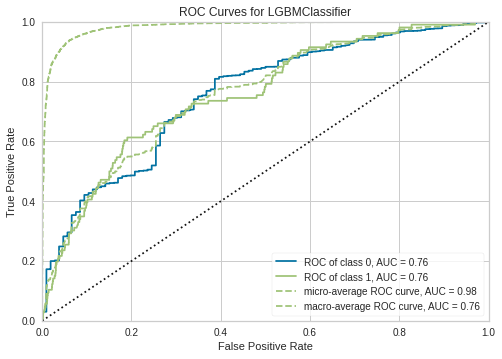

In [24]:
plot_model(lightGBM, plot = 'auc')

# 6. Predictions

In [25]:
predict_model(svm) # on validation data

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,SVM - Linear Kernel,0.8644,0.7546,0.6415,0.0672,0.1216,0.0977,0.1764


,Duration,Net Sales,Commision (in value),Age,Agency_C2B,Agency_LWC,Product Name_Cancellation Plan,Product Name_2 way Comprehensive Plan,Claim,Label
0,0.005328,0.308411,0.248668,0.352273,0.0,0.0,0.0,0.0,0,0
1,0.015574,0.329180,0.000000,0.409091,0.0,0.0,1.0,0.0,0,0
2,0.047336,0.329180,0.000000,0.409091,0.0,0.0,0.0,1.0,0,0
3,0.000615,0.325026,0.015223,0.681818,1.0,0.0,0.0,0.0,0,1
4,0.003279,0.350467,0.038552,0.704545,1.0,0.0,0.0,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...
7235,0.016598,0.391485,0.000000,0.409091,0.0,0.0,1.0,0.0,0,0
7236,0.004303,0.332814,0.022378,0.590909,1.0,0.0,0.0,0.0,0,1
7237,0.000820,0.325026,0.015223,0.363636,1.0,0.0,0.0,0.0,0,1
7238,0.003893,0.391485,0.000000,0.250000,0.0,0.0,1.0,0.0,0,0


In [26]:
predict_model(lightGBM) # on validation data

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9387,0.7558,0.2547,0.0689,0.1084,0.0874,0.108


,Duration,Net Sales,Commision (in value),Age,Agency_C2B,Agency_LWC,Product Name_Cancellation Plan,Product Name_2 way Comprehensive Plan,Claim,Label,Score
0,0.005328,0.308411,0.248668,0.352273,0.0,0.0,0.0,0.0,0,0,0.9996
1,0.015574,0.329180,0.000000,0.409091,0.0,0.0,1.0,0.0,0,0,0.8434
2,0.047336,0.329180,0.000000,0.409091,0.0,0.0,0.0,1.0,0,0,0.6380
3,0.000615,0.325026,0.015223,0.681818,1.0,0.0,0.0,0.0,0,0,0.9865
4,0.003279,0.350467,0.038552,0.704545,1.0,0.0,0.0,0.0,0,1,0.5566
...,...,...,...,...,...,...,...,...,...,...,...
7235,0.016598,0.391485,0.000000,0.409091,0.0,0.0,1.0,0.0,0,0,0.8506
7236,0.004303,0.332814,0.022378,0.590909,1.0,0.0,0.0,0.0,0,1,0.6337
7237,0.000820,0.325026,0.015223,0.363636,1.0,0.0,0.0,0.0,0,0,0.5684
7238,0.003893,0.391485,0.000000,0.250000,0.0,0.0,1.0,0.0,0,0,0.9951


In [27]:
# Make Prediction on Test Dataset
predictions=predict_model(lightGBM, data=test_ins)
target=predictions['Label']

res = pd.DataFrame(target) 
res.index = test_ins.index 
res.columns = ["prediction"]

# To download the csv file locally
from google.colab import files
res.to_csv('submission.csv', index=False)         
files.download('submission.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The score obtained by uploading the submission at the Dphi website is 11.428571428571429. Top score in the leaderboard is 16.176470588235293. So I guess my results are not bad considering I didn't adjust hyperparameters or changed the data and models too much.

In [28]:
#Final model parameters for deployment
final_svm = finalize_model(svm)
print(final_svm)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.001, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
              power_t=0.5, random_state=123, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
